# IMPORTS

In [1]:
# data visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# logger.
import pickle
import mlflow

In [2]:
# tensor calculus backend.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# neural networks abstractions.
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, \
                                    Flatten, \
                                    Dense, \
                                    Dropout, \
                                    AveragePooling2D

# monitoring metrics and callbacks.
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

# confere data.
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt
import cv2
import natsort
import seaborn as sns

2023-08-07 20:19:38.526530: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 20:19:38.574920: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 20:19:38.575559: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 20:19:39.455429: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Dev parameters

In [3]:
import sys
sys.path.insert(1, '../')

# get parameters.
from dev_modules.vcs_params import params_dataset
from dev_modules.vcs_params import params_lite

# import custom model.
from dev_modules.vcs_model import model_class

# LOGGER

In [4]:
mlflow.tensorflow.autolog()
mlflow.start_run(run_name=params_lite.LITE_RUN_NAME)

mlflow.log_artifact("../dev_modules/")
mlflow.log_params(model_class.TRAIN_HYPER)

In [5]:
tf.keras.utils.set_random_seed(params_lite.RANDOM_SEED)

# TRAINING GEN

In [6]:
dir_train = os.path.join("..",
                         params_dataset.DATASET_ROOT_DIR,
                         params_dataset.DATASET_TYPE,
                         params_dataset.TRAIN_DIR)

# training
train_gen = ImageDataGenerator(**params_lite.TRAINING_GEN_PARAMS)

print('Training set: ')
train_set = train_gen.flow_from_directory(directory=dir_train,
                                          subset='training',
                                          **params_lite.TRAINING_FLOW_PARAMS)
print(train_set.class_indices)

train_files = train_set._filepaths
train_files = natsort.natsorted(train_files)

print('\nValidation set: ')
valid_set = train_gen.flow_from_directory(directory=dir_train,
                                          subset='validation',
                                          **params_lite.TRAINING_FLOW_PARAMS)
print(valid_set.class_indices)

valid_files = valid_set._filepaths
valid_files = natsort.natsorted(valid_files)

Training set: 
Found 892 images belonging to 2 classes.
{'0_utilizavel': 0, '1_defeituoso': 1}

Validation set: 
Found 222 images belonging to 2 classes.
{'0_utilizavel': 0, '1_defeituoso': 1}


In [7]:
lite_outputs_dir = os.path.join('.', params_lite.LITE_OUTPUTS_DIR)
TRAIN_FILES = os.path.join(lite_outputs_dir, params_lite.TRAIN_FILES)
VAL_FILES = os.path.join(lite_outputs_dir, params_lite.VAL_FILES)
os.makedirs(lite_outputs_dir)

for sets_files in zip([TRAIN_FILES, VAL_FILES], [train_files, valid_files]):
    with open(sets_files[0], 'wb') as file:
        pickle.dump(sets_files[1], file)

# LOAD MODEL

In [8]:
loaded_model = tf.keras.models.load_model(params_lite.TRAINED_MODEL)

# QUANTIZE MODEL

In [9]:
# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset_gen() -> np.ndarray:
  """
  Provide representative dataset to quantization.
  """
  for path in train_set._filepaths:
    sample = np.float32(cv2.imread(path, cv2.IMREAD_GRAYSCALE) )
    yield([ sample.reshape(-1, *sample.shape , 1)])

In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)

# Enforce integer 8 bits quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Create lite model.
converter.representative_dataset = representative_dataset_gen
model_tflite = converter.convert()

# Save the model in disk.
open(params_lite.LITE_MODEL_DIR, "wb").write(model_tflite)

INFO:tensorflow:Assets written to: /tmp/tmp7kg8vord/assets


INFO:tensorflow:Assets written to: /tmp/tmp7kg8vord/assets
/home/vuser/Documents/backup_07302023/3_tcc_code/ML_IoT_pipeline/ML_IoT_pipeline/env_ML_pipeline/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-08-07 20:19:43.214624: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-08-07 20:19:43.214653: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-08-07 20:19:43.215351: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7kg8vord
2023-08-07 20:19:43.218376: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-08-07 20:19:43.218413: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmp7kg8vord
2023-08-07 20:19:43.224895: I tensorflow/compi

9784

In [11]:
interpreter = tf.lite.Interpreter(model_content=model_tflite)
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

print('input details =', input_details)
print('output details =', output_details)

input details = {'name': 'serving_default_conv2d_input:0', 'index': 0, 'shape': array([  1, 128, 128,   1], dtype=int32), 'shape_signature': array([ -1, 128, 128,   1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (1.0, -128), 'quantization_parameters': {'scales': array([1.], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
output details = {'name': 'StatefulPartitionedCall:0', 'index': 25, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


# LITE INFERENCE

In [12]:
def predict_tflite(tflite_model, x_test):
  """
  Routine to do inferences in tflite model.
  Return the predictions.
  """
  x_input_ = x_test.copy()
  x_input_ = x_input_
  x_input_ = x_input_.astype(np.float32)

  # Initialize the TFLite interpreter.
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # Scale and quantize the input layer.
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_input_ = x_input_ / input_scale + input_zero_point
    x_input_ = x_input_.astype(input_details["dtype"])
  
  # Invoke the interpreter.
  y_pred = np.empty(x_input_.size, dtype=output_details["dtype"])
  for i in range(len(x_input_)):
    interpreter.set_tensor(input_details["index"], [x_input_[i]])
    interpreter.invoke()
    y_pred[i] = interpreter.get_tensor(output_details["index"])[0]
  
  # Dequantize the output layer.
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return y_pred

In [13]:
def visualize_errors(files_set: list,
                     save_dir: str,
                     number_to_plot: int = 5) -> None:
    """
    Visualize and save predicted errors.
    Return files that the model infered wrong.
    """
    os.makedirs(save_dir, exist_ok=True)
    wrong_inference = list()
    
    FP_count = 0
    FN_count = 0
    for file in files_set:
        ground_truth = int(file.split('/')[-2][0])
        filename = file.split("/")[-1]

        sample = keras.preprocessing.image.load_img(file, grayscale=True)
        sample = keras.preprocessing.image.img_to_array(sample)
        sample = np.expand_dims(sample, 0)
        pred = loaded_model.predict(sample)
        pred = (pred >= model_class.THRESHOLD_DECISION).reshape(-1,)
        
        diff = pred - ground_truth
        # 0 : ok
        # 1 : pred==1, gt==0 -> FP
        # -1: pred==0, gt==1 -> FN

        if diff:
            wrong_inference.append(filename)
            if diff == 1:
                FP_count += 1
                title = "FP"
                count = FP_count
            else:
                FN_count += 1
                title = "FN"
                count = FN_count
                
            image = sample[0, :, :, 0]
            cv2.imwrite(os.path.join(save_dir, filename), image)
            
            if count <= number_to_plot:
                plt.figure(figsize=(3, 3))
                plt.imshow(image, cmap="gray")
                plt.title(title)
                
    plt.show()
    
    wrong_inference = natsort.natsorted(wrong_inference)
    return wrong_inference

# CONFUSION MATRIX

In [14]:
def draw_confusion_matrix(y_true: np.ndarray,
                          y_pred: np.ndarray,
                          title: str) -> np.ndarray:
    """
    Plot the confusion matrix.
    Return the confusion matrix (skleanr standard).
    """
    # calculate confusion.
    confusion_matrix = sklearn.metrics.confusion_matrix(
        y_true=y_true,
        y_pred=(y_pred >= model_class.THRESHOLD_DECISION).reshape(-1,))
    
    # plot confusion matrix
    ax = sns.heatmap(confusion_matrix,
                     annot=True,
                     annot_kws={'size':14, 'weight':'bold'},
                     fmt='d', cbar=False, cmap='Blues')

    CLASSES_LIST = ['Usable', 'Defective']
    plt.title(title, size=25, weight='bold')

    plt.xlabel('Predicted', size=14, weight='bold')
    ax.set_xticklabels(CLASSES_LIST)

    plt.ylabel('Ground truth', size=14, weight='bold')
    ax.set_yticklabels(CLASSES_LIST, va='center')
    plt.tick_params(axis='both', labelsize=14, length=0)
    plt.show()
    
    return confusion_matrix
    

## Train

In [15]:
y_train_pred = list()
for file in train_files:
    sample = cv2.imread(file, cv2.IMREAD_GRAYSCALE).reshape(-1, 128, 128, 1)
    
    y_train_pred.append(predict_tflite(model_tflite, sample)[0])
y_train_pred = np.array(y_train_pred)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [16]:
y_train_true = train_set.classes[train_set.index_array]
y_train_true = np.array(y_train_true).reshape(y_train_true.size)

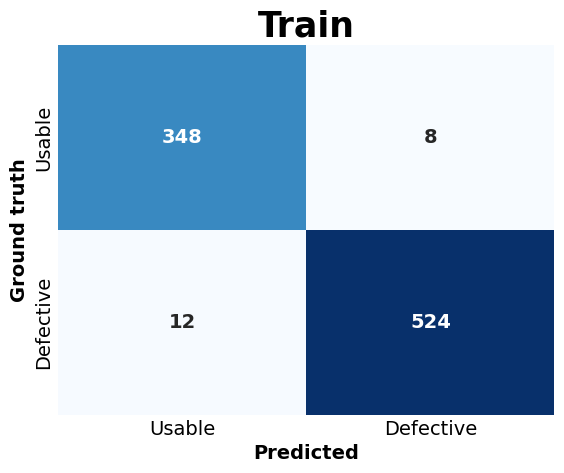

[[348   8]
 [ 12 524]]


In [17]:
train_confusion_matrix = draw_confusion_matrix(
    y_true=y_train_true,
    y_pred=y_train_pred,
    title="Train")
print(train_confusion_matrix)

In [18]:
CONFUSION_TRAIN_FILE = os.path.join(lite_outputs_dir, params_lite.CONFUSION_TRAIN_FILE)
with open(CONFUSION_TRAIN_FILE, 'wb') as file:
    pickle.dump(train_confusion_matrix, file)

## Validation

In [19]:
y_val_pred = list()
for file in valid_files:
    sample = cv2.imread(file, cv2.IMREAD_GRAYSCALE).reshape(-1, 128, 128, 1)
    y_val_pred.append(predict_tflite(model_tflite, sample)[0])
y_val_pred = np.array(y_val_pred)

In [20]:
y_val_true = valid_set.classes[valid_set.index_array]
y_val_true = np.array(y_val_true).reshape(y_val_true.size)

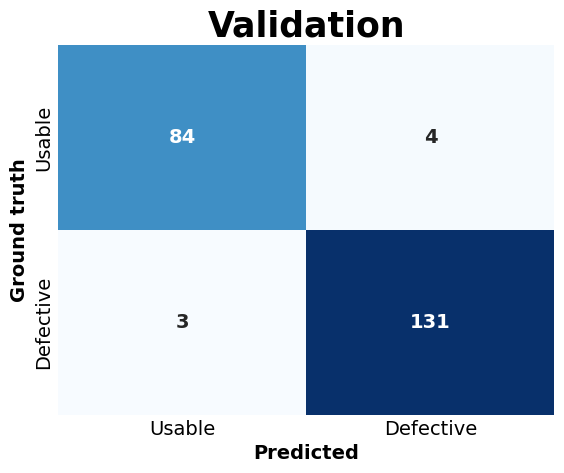

[[ 84   4]
 [  3 131]]


In [21]:
val_confusion_matrix = draw_confusion_matrix(
    y_true=y_val_true,
    y_pred=y_val_pred,
    title="Validation")
print(val_confusion_matrix)

In [22]:
CONFUSION_VAL_FILE = os.path.join(lite_outputs_dir, params_lite.CONFUSION_VAL_FILE)
with open(CONFUSION_VAL_FILE, 'wb') as file:
    pickle.dump(val_confusion_matrix, file)

# VISUALIZE ERRORS

In [23]:
def visualize_errors(files_set: list,
                     save_dir: str,
                     number_to_plot: int = 5) -> None:
    """
    Visualize and save predicted errors.
    Return files that the model infered wrong.
    """
    os.makedirs(save_dir, exist_ok=True)
    wrong_inference = list()
    
    FP_count = 0
    FN_count = 0
    for file in files_set:
        ground_truth = int(file.split('/')[-2][0])
        filename = file.split("/")[-1]

        sample = cv2.imread(file, cv2.IMREAD_GRAYSCALE).reshape(-1, 128, 128, 1)
        pred = predict_tflite(model_tflite, sample)[0]
        pred = (pred >= model_class.THRESHOLD_DECISION).reshape(-1,)
        
        diff = pred - ground_truth
        # 0 : ok
        # 1 : pred==1, gt==0 -> FP
        # -1: pred==0, gt==1 -> FN

        if diff:
            wrong_inference.append(filename)
            if diff == 1:
                FP_count += 1
                title = "FP"
                count = FP_count
            else:
                FN_count += 1
                title = "FN"
                count = FN_count
                
            image = sample[0, :, :, 0]
            cv2.imwrite(os.path.join(save_dir, filename), image)
            
            if count <= number_to_plot:
                plt.figure(figsize=(3, 3))
                plt.imshow(image, cmap="gray")
                plt.title(title)
                
    plt.show()
    
    wrong_inference = natsort.natsorted(wrong_inference)
    return wrong_inference

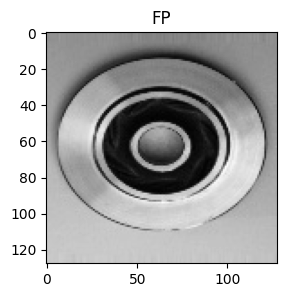

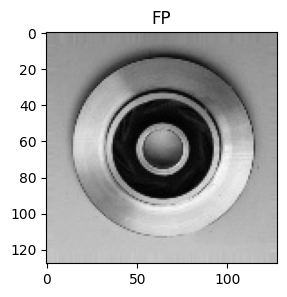

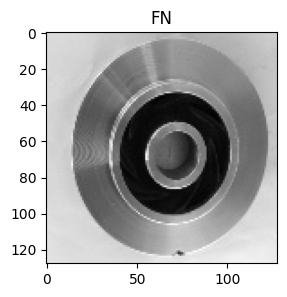

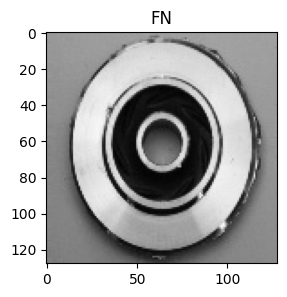

In [24]:
val_errors_dir = os.path.join(lite_outputs_dir, params_lite.VAL_ERRORS_DIR)

wrong_in_val = visualize_errors(valid_files, val_errors_dir, 2)

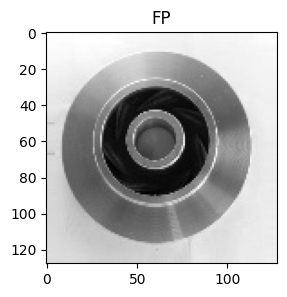

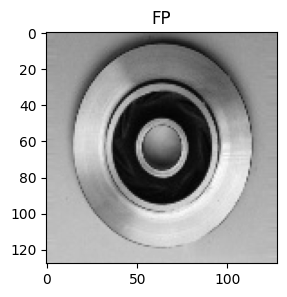

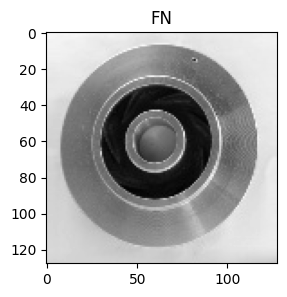

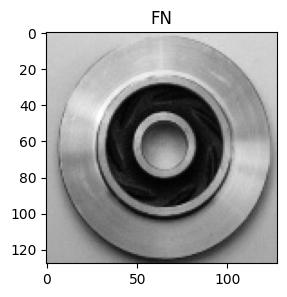

In [25]:
train_errors_dir = os.path.join(lite_outputs_dir, params_lite.TRAIN_ERRORS_DIR)

wrong_in_train = visualize_errors(train_files, train_errors_dir, 2)

In [26]:
WRONG_TRAIN_FILE = os.path.join(lite_outputs_dir, params_lite.WRONG_TRAIN_FILE)
WRONG_VAL_FILE = os.path.join(lite_outputs_dir, params_lite.WRONG_VAL_FILE)

for wrong_files in zip([WRONG_TRAIN_FILE, WRONG_VAL_FILE], [wrong_in_train, wrong_in_val]):
    with open(wrong_files[0], 'wb') as file:
        pickle.dump(wrong_files[1], file)

# FINISH LOG

In [27]:
mlflow.log_artifact(lite_outputs_dir)

In [28]:
mlflow.end_run()